# Introduction

Experimentation on the [UC2018 DualMyo Hand Gesture Dataset](https://zenodo.org/record/1320922#.Xi9l5xfgoWo).

In [1]:
import os, sys, requests, pickle
import numpy as np, sequentia as seq, matplotlib.pyplot as plt
import sequentia.classifiers, sequentia.preprocessing
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

# Import utility tools
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import *
from lstm import LSTMClassifier

# ggplot style
plt.style.use('ggplot')

# Set seed for reproducible randomness
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed)

In [2]:
n_classes = 8
classes = [str(i) for i in range(n_classes)]
classes

['0', '1', '2', '3', '4', '5', '6', '7']

In [3]:
X, y = [], []
url = 'https://zenodo.org/record/1320922/files/dualmyo_dataset.pkl'

try:
    file = 'dualmyo_dataset.pkl'
    print('Downloading dataset from {} ...'.format(url))
    response = requests.get(url)
    with open(file, 'wb') as f:
        print('Writing {} ...'.format(file))
        f.write(response.content)
except:
    raise
else:
    print('Unpickling data into Numpy arrays ...')
    data = pickle.load(open(file, 'rb'))
    X = data[0]
    y = [str(label) for label in data[1]]
    print('Done!')
finally:
    os.remove(file)

Writing dualmyo_dataset.pkl ...
Unpickling data into Numpy arrays ...
Done!


In [4]:
# Shuffle and split the data into training, validation and test sets (65-20-15)
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.35, shuffle=True, random_state=rng)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.43, shuffle=True, random_state=rng)

# Display the split sizes
print('Training set size: {}'.format(len(y_train)))
print('Validation set size: {}'.format(len(y_val)))
print('Test set size: {}'.format(len(y_test)))

Training set size: 572
Validation set size: 176
Test set size: 133


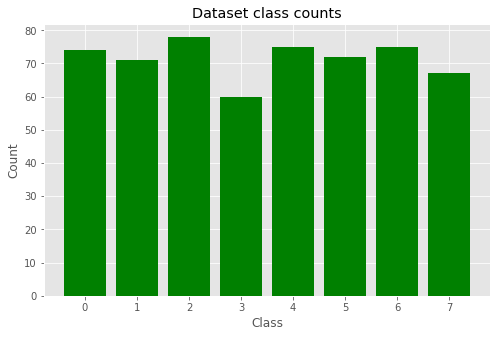

In [5]:
# Plot a chart of the class counts in the training set
show_class_counts(y_train, classes)

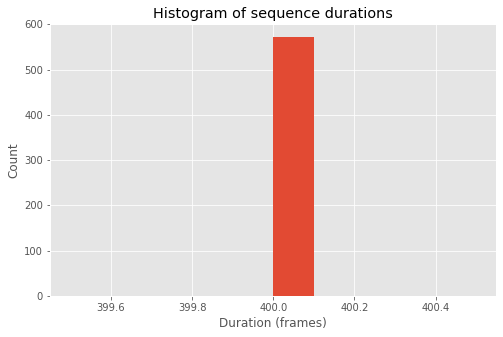

In [6]:
# Plot a histogram of signal durations
show_durations(X_train)

In [7]:
# This setting works well!
pre = seq.preprocessing.Preprocess()
pre.downsample(n=10, method='decimate')
pre.filtrate(n=10, method='median')
pre.center()
pre.summary()

           Preprocessing summary:          
1. Downsampling:
   Decimation with downsample factor (n=10)
-------------------------------------------
2. Filtering:
   Median filter with window size (n=10)
-------------------------------------------
3. Centering


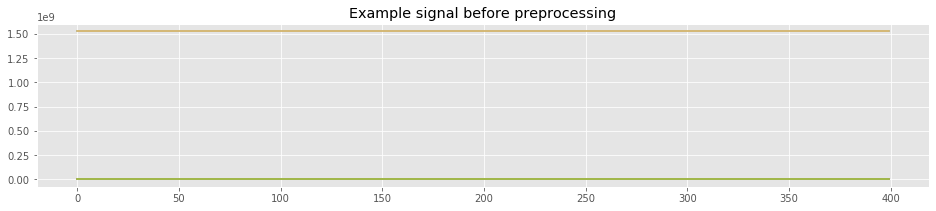

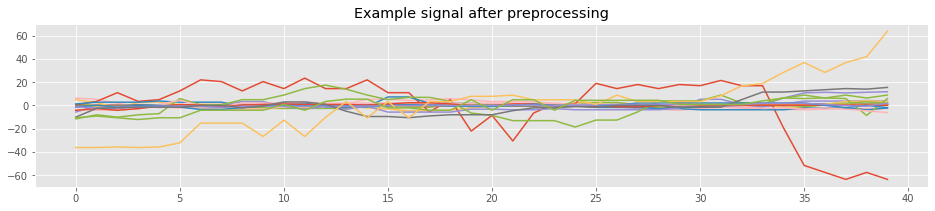

In [8]:
# Pick an example signal for visualization
x = X_train[1]

plt.figure(figsize=(16, 3))
plt.title('Example signal before preprocessing')
plt.plot(x)
plt.show()

plt.figure(figsize=(16, 3))
plt.title('Example signal after preprocessing')
plt.plot(pre.transform(x))
plt.show()

In [9]:
X_train_pre, X_val_pre, X_test_pre = pre.transform(X_train), pre.transform(X_val), pre.transform(X_test)

## Hidden Markov Model classifier

### Fitting the model

In [10]:
%%time

# Create HMMs to represent each class
#
# NumPy sometimes raises some errors as a result of instability during the Cholesky decomposition.
# According to issue #414 on Pomegranate's GitHub repository, this may be caused by:
# - Too many states in the HMMs
# - Too many dimensions in the input data, which leads to a large covariance matrix
# - Too few training examples
hmms = []
for c in tqdm(classes, desc='Training HMMs'):
    hmm = seq.classifiers.HMM(label=c, n_states=5, random_state=rng)
    hmm.set_random_initial()
    hmm.set_random_transitions()
    hmm.fit([X_train_pre[i] for i, label in enumerate(y_train) if label == c])
    hmms.append(hmm)
    
# Fit a HMM classifier with the HMMs
clf = seq.classifiers.HMMClassifier()
clf.fit(hmms)


CPU times: user 20.6 s, sys: 202 ms, total: 20.8 s
Wall time: 21.2 s


### Evaluating the model

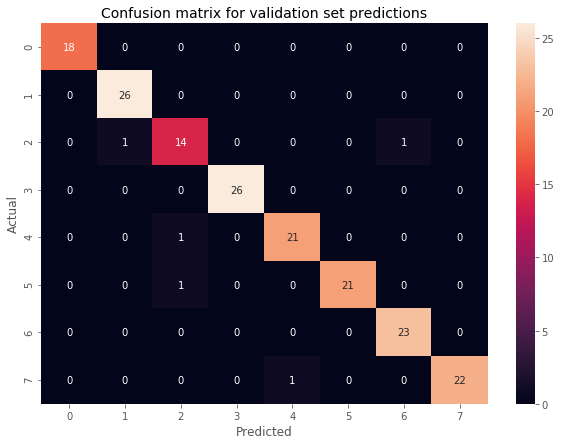

Accuracy: 97.16%
CPU times: user 586 ms, sys: 25.5 ms, total: 611 ms
Wall time: 631 ms


In [11]:
%%time
acc, cm = clf.evaluate(X_val_pre, y_val, labels=classes)
show_results(acc, cm, dataset='validation', labels=classes)

## LSTM classifier

### Fitting the model

In [12]:
%%time
clf = LSTMClassifier(epochs=30, batch_size=64, classes=classes)
hist = clf.fit(X_train_pre, y_train, validation_data=(X_val_pre, y_val), return_history=True)

Train on 572 samples, validate on 176 samples
Epoch 1/30
572/572 [==============================] - 3s 5ms/sample - loss: 2.1824 - accuracy: 0.1311 - val_loss: 2.0510 - val_accuracy: 0.1875
Epoch 2/30
572/572 [==============================] - 1s 1ms/sample - loss: 1.9463 - accuracy: 0.2622 - val_loss: 1.9338 - val_accuracy: 0.3068
Epoch 3/30
572/572 [==============================] - 1s 1ms/sample - loss: 1.8457 - accuracy: 0.3549 - val_loss: 1.8183 - val_accuracy: 0.3977
Epoch 4/30
572/572 [==============================] - 1s 1ms/sample - loss: 1.6473 - accuracy: 0.4685 - val_loss: 1.6915 - val_accuracy: 0.4261
Epoch 5/30
572/572 [==============================] - 1s 1ms/sample - loss: 1.4780 - accuracy: 0.5315 - val_loss: 1.5468 - val_accuracy: 0.4886
Epoch 6/30
572/572 [==============================] - 1s 994us/sample - loss: 1.3124 - accuracy: 0.5874 - val_loss: 1.4179 - val_accuracy: 0.4943
Epoch 7/30
572/572 [==============================] - 1s 1ms/sample - loss: 1.1644 - acc

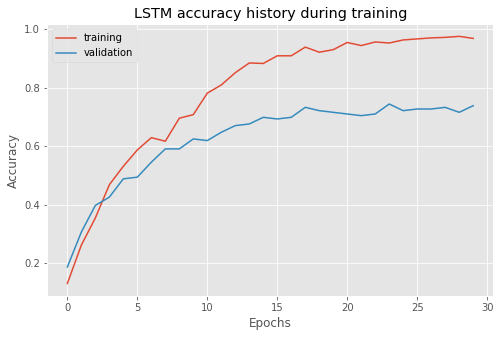

In [13]:
# Display accuracy history during training
show_accuracy_history(hist)

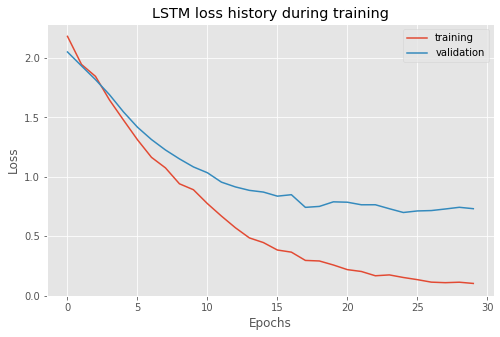

In [14]:
# Display loss history during training
show_loss_history(hist)

### Evaluating the model

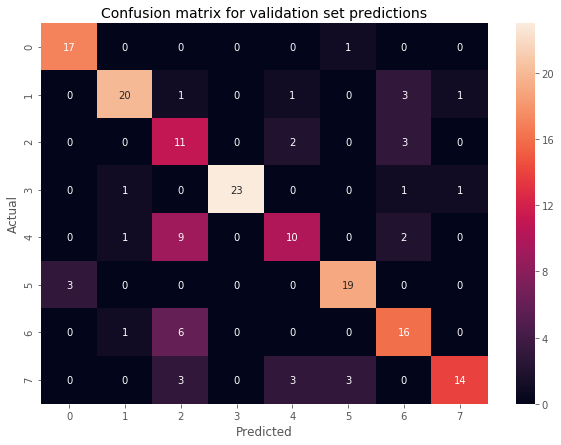

Accuracy: 73.86%
CPU times: user 866 ms, sys: 59.5 ms, total: 926 ms
Wall time: 915 ms


In [15]:
%%time
acc, cm = clf.evaluate(X_val_pre, y_val)
show_results(acc, cm, dataset='validation', labels=classes)